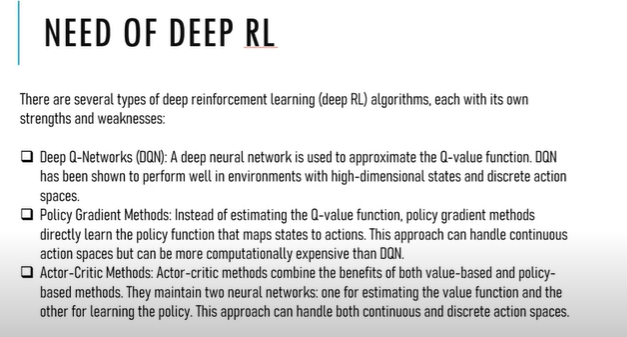

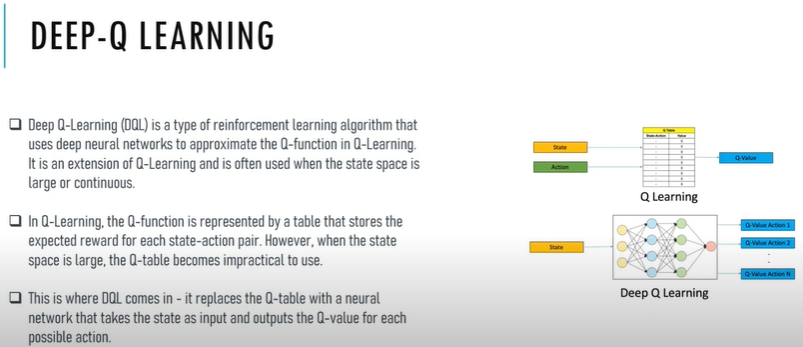

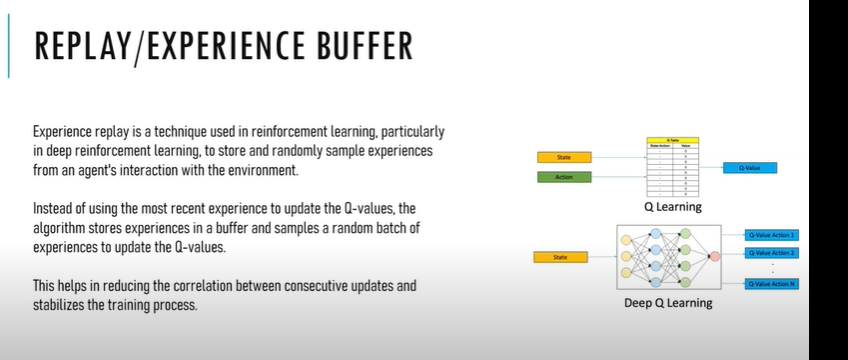

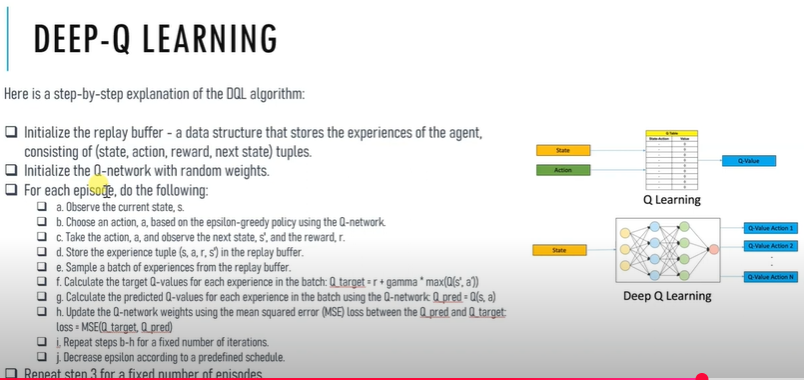

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from collections import deque

In [5]:
cust_map = [
    'FFFF',
    'FHFH',
    'HFFF',
    'HFFG',
]


In [6]:
env = gym.make("FrozenLake-v1", desc=cust_map, is_slippery=False)
episodes = 300
test = 100
max_steps = 300
state_size = env.observation_space.n
action_size = env.action_space.n
batch_size=32

d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\site-packages\gym\envs\toy_text\frozen_lake.py:181: RuntimeWarning: invalid value encountered in divide
  self.initial_state_distrib /= self.initial_state_distrib.sum()


In [10]:
class DQN:
    def __init__(self, state_size, action_size):
        self.memory = deque(maxlen=2500)
        self.learning_rate = 0.001
        self.epsilon = 1
        self.max_eps=1
        self.min_eps = 0.01
        self.eps_decay = 0.0003
        self.gamma = 0.9
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon_lst = []
        self.model = self.built_model_dqn()
        
    def built_model_dqn(self):
        model = Sequential()
        model.add(Dense(10, input_dim=self.state_size, activation='relu'))
        model.add(Dense(10, input_dim=self.state_size, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate = self.learning_rate))
        return model
    def remember(self, new_state, reward, done, state, action):
        self.memory.append((new_state, reward, done, state, action))
        
    def action(self, state):
        if np.random.rand() > self.epsilon:
            return np.random.randint(0,4)
        return np.argmax(self.model.predict(state))
    
    def pred(self, state):
        return np.argmax(self.model.predict(state))
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for new_state, reward, done, state, action in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma*np.amax(self.model.predict(state))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
                
        if self.epsilon > self.min_eps:
            self.epsilon = (self.max_eps-self.min_eps) * np.exp(-self.eps_decay*episodes) + self.min_eps
        self.epsilon_lst.append(self.epsilon)
        
    def load(self, name):
        self.model.load_weights(name)     
        
    def save(self, name):
        self.model.save_weights(name)

In [11]:
agent_ = DQN(state_size, action_size)    

d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
reward_lst = []

In [14]:
for episode in range(20): # episodes
    state = env.reset()[0]
    state_arr = np.zeros(state_size)
    state_arr[state] = 1
    state = np.reshape(state_arr, [1, state_size])
    reward = 0
    done = False
    for i in range(max_steps):
        #env.render()
        action = agent_.action(state)
        new_state, reward, done, info = env.step(action)
        new_state_arr = np.zeros(state_size)
        new_state_arr[new_state] = 1
        new_state = np.reshape(new_state_arr, [1, state_size])
        agent_.remember(new_state, reward, done, state, action)
        state = new_state
        
        if done:
            print(f"Episode: {episode:4}/{episodes} and step: {i:4}. Eps:{float(agent_.epsilon):.2}, reward {reward}")
            break
    reward_lst.append(reward)
    
    if len(agent_.memory) > batch_size:
        agent_.replay(batch_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


AttributeError: module 'numpy' has no attribute 'bool8'

In [ ]:
print('Mean % Score = ', round(100*np.mean(reward_lst),1))

In [ ]:

#Evaluation

eval_reward_lst = []
for episode in range(test):
    state = env.reset()
    state_arr = np.zeros(state_size)
    state_arr[state] = 1
    state = np.reshape(state_arr, [1, state_size])
    reward = 0
    done = False
    state_lst = []
    state_lst.append(state)
    for j in range(max_steps):
        #env.render()
        action = agent_.pred(state)
        new_state, reward, done, info = env.step(action)
        new_state_arr = np.zeros(state_size)
        new_state_arr[new_state] = 1
        new_state = np.reshape(new_state_arr, [1, state_size])
        state = new_state
        state_lst.append(state)
        
        if done:
            print(reward)
            break
    eval_reward_lst.append(reward)
print('Eval Mean % Score = ', round(100*np.mean(eval_reward_lst),1))


In [ ]:
fig = plt.figure(figsize = (10, 12))
plt.rcParams.clear()
plt.rcParams.update({'font.szie': 22})
plt.subplot(311)
plt.scatter(list(range(len(reward_lst))), reward_lst, s=0.2)
plt.title("4X4 Fronzen Lake Result(DQN)")
plt.ylabel('Train Score')
plt.xlabel('Episode')
        
plt.subplot(312)
plt.scatter(list(range(len(agent_.epsilon_lst))), agent_.epsilon_lst, s=0.2)
plt.title("Epsilon")
plt.ylabel('Epsilon')
plt.xlabel('Episode')

plt.subplot(313)
plt.scatter(list(range(len(eval_reward_lst))), eval_reward_lst, s=0.2)
plt.title("Evaluation")
plt.ylabel('Test Score')
plt.xlabel('Episode')
plt.show()

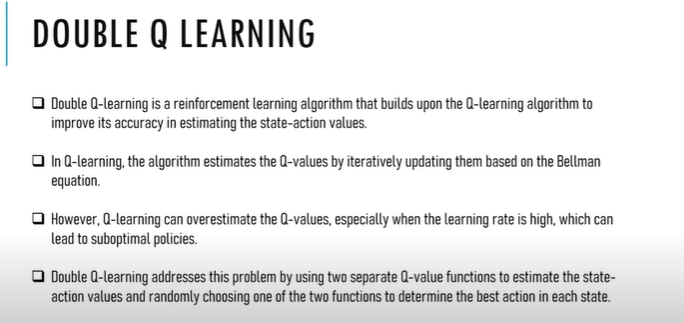

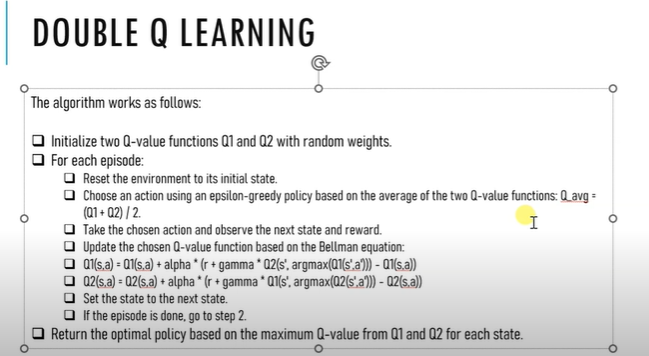
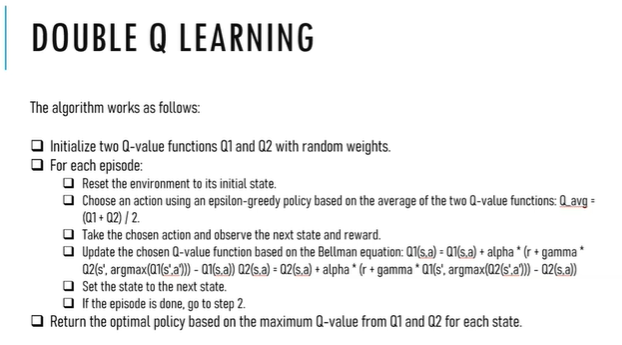

In [15]:
class DoubleQLearning:
    def __init__(self, alpha, gamma, epsilon, actions):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = actions
        self.q1 = {}
        self.q2 = {}
        self.state = None
        self.action = None
        
    def update(self, reward, next_state):
        if random.random() < 0.5:
            self.q1[(self.state, self.action)] = self.q1.get((self.state, self.action), 0) + self.alpha * (reward + self.gamma * self.q2.get((next_state, self._argmax(self.q1, next_state)), 0) - self.q1.get((self.state, self.action), 0))
        else:    
            self.q2[(self.state, self.action)] = self.q2.get((self.state, self.action), 0) + self.alpha * (reward + self.gamma * self.q1.get((next_state, self._argmax(self.q2, next_state)), 0) - self.q2.get((self.state, self.action), 0))
        self.state = next_state
        
    def act(self, state):
        self.state = state
        if random.random() < self.epsilon:
            self.action = random.choice(self.actions)
        else:
            if random.random() < 0.5:
                self.action = self._argmax(self.q1, state)
            else:
                self.action = self._argmax(self.q2, state)
        return self.action
    
    def _argmax(self, d, state):
        best_action = None
        best_value = float('-inf')
        for a in self.actions:
            if (state, a) in d and d[(state, a)] > best_value:
                best_Value = d[(state, a)]
                best_action = a
            if best_action is None:
                return random.choice(self.actions)
            else:
                return best_action

In [16]:
env = gym.make('FrozenLake-v1')

actions = range(env.action_space.n)
agent = DoubleQLearning(alpha = 0.5,
                       gamma = 0.99,
                       epsilon = 0.1,
                       actions = actions)


In [18]:
#Train the agent
num_episodes = 10
episode_rewards = np.zeros(num_episodes)
for i in range(num_episodes):
    state = env.reset()[0]
    done = False
    episode_reward = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(reward, next_state)
        episode_reward += reward
        state = next_state
    episode_rewards[i] = episode_reward
    
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

AttributeError: module 'numpy' has no attribute 'bool8'

In [20]:
## Testing
nul_eval_episodes = 10
eval_episode_rewards = np.zeros(nul_eval_episodes)
for i in range(nul_eval_episodes):
    state = env.reset()[0]
    done = False
    eval_episode_reward = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        eval_episode_reward += reward
        state = next_state
    eval_episode_rewards[i] = eval_episode_reward
#print avg. reward
print("Average evaluation episode reward: {}".format(np.mean(eval_episode_rewards)))

ValueError: too many values to unpack (expected 4)